In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from scipy import stats

In [0]:
datasets_config = [
    ('output_label_idle.txt', 'idle'),
    ('output_label_idle_2.txt', 'idle'),
    ('output_label_working.txt', 'working'),
    ('output_label_working_2.txt', 'working')
]

column_names = ['ax', 'ay', 'az']

def load_dataset(config):
    dataframes = []
    for filename, label in config:
        dataframe = pd.read_csv(filename, names=column_names)
        dataframe['label'] = label
        dataframes.append(dataframe)
    
    return pd.concat(dataframes)

In [4]:
dataset = load_dataset(datasets_config)

for label in np.unique(dataset['label']):
    print("{}: {}".format(label, len(dataset[dataset['label'] == label])))

idle: 102873
working: 103598


In [0]:
def plot_axis(axis, data, title):
  axis.plot(data)
  axis.set_title(title)
  axis.xaxis.set_visible(False)
  axis.set_ylim([min(data)-np.std(data),max(data)+np.std(data)])
  axis.grid(True)

def plot_activity(activity, data):
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
  plot_axis(ax0, data["ax"], "X Axis")
  plot_axis(ax1, data["ay"], "Y Axis")
  plot_axis(ax2, data["az"], "Z Axis")
  plt.subplots_adjust(hspace=0.2)
  fig.suptitle(activity)
  plt.subplots_adjust(top=0.9)
  plt.show()

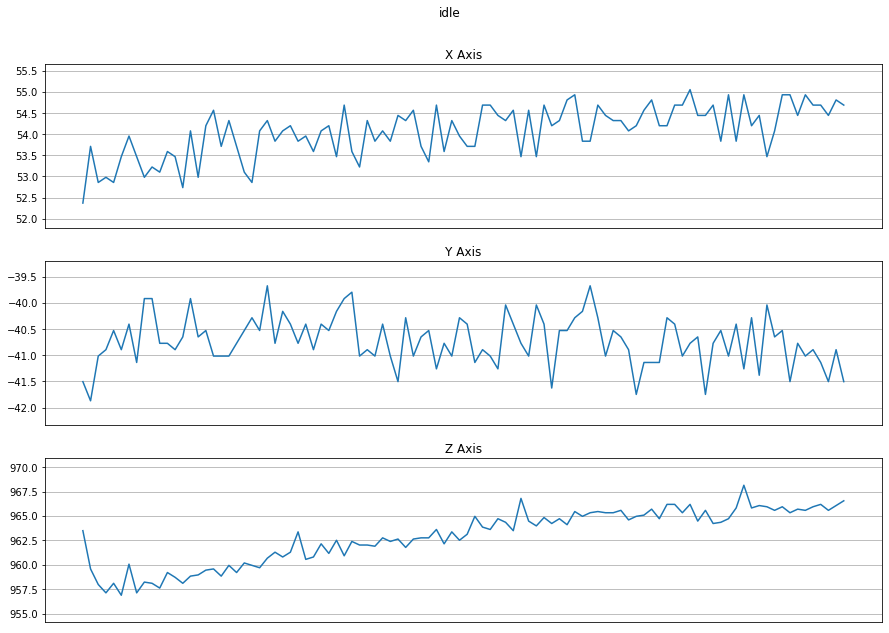

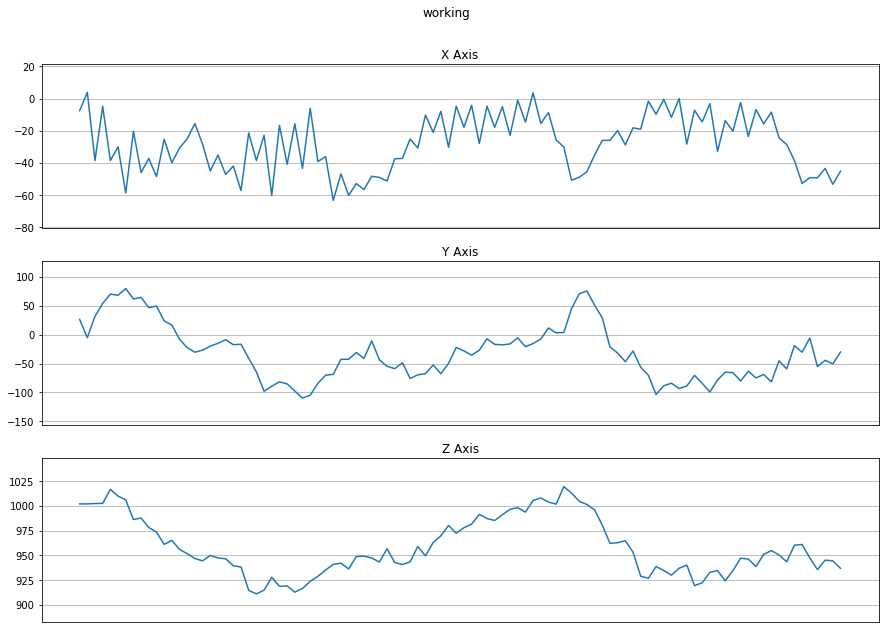

In [6]:
for activity in np.unique(dataset['label']):
    subset = dataset[dataset['label'] == activity][:100]
    plot_activity(activity, subset)

In [0]:
def windows(data, size):
    start = 0
    while start < len(data):
        yield int(start), int(start + size)
        start += size

def segment_signals(data, window_size = 100):
    data_per_class = []
    
    for label in np.unique(data['label']):
        subset = data[data['label'] == label]
        length = len(subset)
        remaining = length % window_size
        max_length = length - remaining
        data_per_class.append(subset[:max_length])

    trimmed_data = pd.concat(data_per_class)
    
    result = []
    labels = []
    
    for (start, end) in windows(trimmed_data, window_size):
        row = []
        x_axes = data['ax'][start:end] / 1000.0
        y_axes = data['ay'][start:end] / 1000.0
        z_axes = data['az'][start:end] / 1000.0
        
        for x, y, z in zip(x_axes, y_axes, z_axes):
            row.append(x)
            row.append(y)
            row.append(z)
        row = np.array(row)
        row = row.reshape((100, 3))
        label = stats.mode(trimmed_data['label'][start:end])[0][0]
        
        result.append(row)
        labels.append(label)
    return np.array(result), np.array(labels)

In [0]:
segments, labels = segment_signals(dataset, 100)

In [9]:
segments.shape

(2063, 100, 3)

In [0]:
labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)

In [0]:
n_rows = segments.shape[1]
n_cols = segments.shape[2]
n_channels = 1
n_filters = 16
kernel_size = 2
pooling_window_size = 2
n_fc_layer= 16
train_split_ratio = 0.8
epochs = 100
batch_size = 10
n_class = labels.shape[1]
dropout_ratio = 0.1

In [12]:
reshaped_segments = segments.reshape(segments.shape[0], n_rows, n_cols, 1)
reshaped_segments.shape

(2063, 100, 3, 1)

In [0]:
train_split = np.random.rand(len(reshaped_segments)) < train_split_ratio

In [14]:
train_x = reshaped_segments[train_split]
test_x = reshaped_segments[~train_split]
train_x = np.nan_to_num(train_x)
test_x = np.nan_to_num(test_x)
train_y = labels[train_split]
test_y = labels[~train_split]



# train_x, test_x, train_y, test_y = train_test_split(reshaped_segments, labels, test_size=.3, random_state=611)
print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)

Train X shape: (1651, 100, 3, 1)
Train Y shape: (1651, 2)


In [0]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(n_filters, (kernel_size, kernel_size), input_shape=(n_rows, n_cols, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D((pooling_window_size, pooling_window_size)))
    model.add(Dropout(dropout_ratio))
    model.add(Flatten())
    model.add(Dense(n_fc_layer, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(n_class, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
    
    return model

In [16]:
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 3, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 1, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                12816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3

In [17]:
history = model.fit(train_x,
          train_y,
          epochs=epochs,
          validation_split=1-train_split_ratio,
          batch_size=batch_size)

Train on 1320 samples, validate on 331 samples
Epoch 1/100
1320/1320 [==============================] - 7s 5ms/sample - loss: 0.6502 - accuracy: 0.6311 - val_loss: 0.8880 - val_accuracy: 0.0000e+00
Epoch 2/100
1320/1320 [==============================] - 0s 311us/sample - loss: 0.6263 - accuracy: 0.6447 - val_loss: 0.9013 - val_accuracy: 0.0151
Epoch 3/100
1320/1320 [==============================] - 0s 303us/sample - loss: 0.6081 - accuracy: 0.6545 - val_loss: 0.8653 - val_accuracy: 0.0423
Epoch 4/100
1320/1320 [==============================] - 0s 309us/sample - loss: 0.5983 - accuracy: 0.6598 - val_loss: 0.8747 - val_accuracy: 0.0604
Epoch 5/100
1320/1320 [==============================] - 0s 314us/sample - loss: 0.5839 - accuracy: 0.6682 - val_loss: 0.8402 - val_accuracy: 0.0816
Epoch 6/100
1320/1320 [==============================] - 0s 303us/sample - loss: 0.5724 - accuracy: 0.6924 - val_loss: 0.7947 - val_accuracy: 0.1571
Epoch 7/100
1320/1320 [==============================] - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


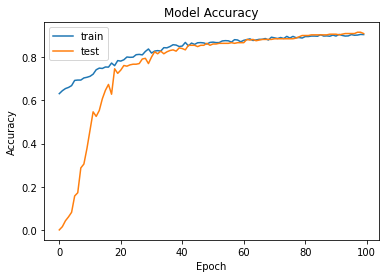

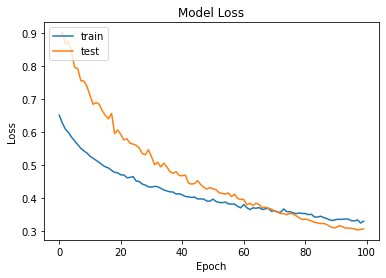

In [18]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
score = model.evaluate(test_x, test_y)

412/412 [==============================] - 0s 124us/sample - loss: 0.3499 - accuracy: 0.8859


In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

53556

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("model_quantized.tflite", "wb").write(tflite_model)

15200

In [22]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i model.tflite > /content/model.cc
# Print the source file
!cat /content/model.cc

Selecting previously unselected package xxd.
(Reading database ... 144542 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.1_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.1) ...
Setting up xxd (2:8.0.1453-1ubuntu1.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0xcc, 0xd0, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0xec, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0xb4, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x54, 0x4f, 0x43, 0x4f, 0x20, 0x43, 0x6f, 0x6e,
  0x76, 0x65, 0x72, 0x74, 0x65, 0x64, 0x2e, 0x00, 0x0e, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0x7c, 0x00, 0x00, 0x00, 0x